In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Genetic algorithm for hyperparameter optimization on the mnist dataset.
Credits: https://github.com/guibacellar/OpenAi/blob/master/CartPole-GA.py

In [3]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, InputLayer
from keras import backend as K
from keras.utils import to_categorical
from matplotlib import pyplot
import ipywidgets

# pyplot.style.use(['dark_background'])

In [4]:
# local imports
from gahyperopt import *

In [5]:
# Define Hyperparameters for NN
HIDDEN_LAYER_COUNT = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
HIDDEN_LAYER_NEURONS = [8, 16, 24, 32, 64, 128, 256, 512]
HIDDEN_LAYER_RATE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
HIDDEN_LAYER_ACTIVATIONS = ['relu', 'tanh', 'sigmoid']
HIDDEN_LAYER_TYPE = ['dense', 'dropout']
MODEL_OPTIMIZER = ['rmsprop', 'adams', 'sgd']

# Define Genetic Algorithm Parameters
MAX_GENERATIONS = 100  # Max Number of Generations to Apply the Genetic Algorithm
POPULATION_SIZE = 8  # Max Number of Individuals in Each Population
BEST_CANDIDATES_COUNT = 2  # Number of Best Candidates to Use
RANDOM_CANDIDATES_COUNT = 1  # Number of Random Candidates (From Entire Population of Generation) to Next Population
OPTIMIZER_MUTATION_PROBABILITY = 0.3  # 10% of Probability to Apply Mutation on Optimizer Parameter
HIDDEN_LAYER_MUTATION_PROBABILITY = 0.4  # 10% of Probability to Apply Mutation on Hidden Layer Quantity

In [6]:
ga = GADriver(layer_counts=HIDDEN_LAYER_COUNT,
                     no_neurons=HIDDEN_LAYER_NEURONS,
                     rates=HIDDEN_LAYER_RATE,
                     activations=HIDDEN_LAYER_ACTIVATIONS,
                     layer_types=HIDDEN_LAYER_TYPE,
                     optimizers=MODEL_OPTIMIZER,
                     population_size=POPULATION_SIZE,
                     best_candidates_count=BEST_CANDIDATES_COUNT,
                     random_candidates_count=RANDOM_CANDIDATES_COUNT,
                     optimizer_mutation_probability=OPTIMIZER_MUTATION_PROBABILITY,
                     layer_mutation_probability=HIDDEN_LAYER_MUTATION_PROBABILITY,
                    )

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [8]:
# Get test and training data.
data = load_mnist()

In [19]:
@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=40000-1, step=100, value=0))
def plot_mnist_figure(i):
    print(data['y_train'][i])
    pyplot.imshow(data['x_train'][i].reshape(28,28), cmap='bone_r')

interactive(children=(IntSlider(value=0, description='i', max=39999, step=100), Output()), _dom_classes=('widg…

In [10]:
def generate_reference_ml(data):
    """
    Train and Generate NN Model based on https://github.com/fchollet/deep-learning-with-python-notebooks/blobs/master/2.1-a-first-look-at-a-neural-netword.ipynb'
    :param df: Dataframe to Training Process
    :return:
    """
    print("[+] Training Original NN Model: ", end='')
    run_start = time.time()

    # Define Neural model Topology
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
    model.add(Dense(10, activation='softmax'))

    # Compile Neural model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Fit Model with Data
    x_train, y_train, x_val, y_val = data.values()
    training = model.fit(x_train, y_train,
        epochs=20,
        batch_size=128,
        steps_per_epoch=300,
        verbose=1,
        validation_data=(x_val, y_val),
    )

    run_stop = time.time()
    print(f"Done > Takes {run_stop-run_start} sec")

    return model, training


In [11]:
# Creates a Reference NN Model based on 
ml_model, training = generate_reference_ml(data)

[+] Training Original NN Model: 

2022-02-21 12:04:55.566826: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-21 12:04:55.650094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-21 12:04:55.650330: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-21 12:04:55.652281: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-21 12:04:55.654392: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-21 12:04:55.654740: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2022-02-21 12:04:57.100202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


300/300 [==============================] - 2s 5ms/step - loss: 0.3067 - accuracy: 0.9120 - val_loss: 0.1682 - val_accuracy: 0.9514
Epoch 2/20
300/300 [==============================] - 1s 5ms/step - loss: 0.1315 - accuracy: 0.9604 - val_loss: 0.1304 - val_accuracy: 0.9608
Epoch 3/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0849 - accuracy: 0.9745 - val_loss: 0.1087 - val_accuracy: 0.9689
Epoch 4/20
300/300 [==============================] - 2s 5ms/step - loss: 0.0634 - accuracy: 0.9814 - val_loss: 0.0996 - val_accuracy: 0.9712
Epoch 5/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0463 - accuracy: 0.9861 - val_loss: 0.0933 - val_accuracy: 0.9736
Epoch 6/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0353 - accuracy: 0.9900 - val_loss: 0.0974 - val_accuracy: 0.9730
Epoch 7/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.0925 - val_accuracy: 0.9742
Epoch 8/20
300/30

In [12]:
from tensorflow.keras.utils import plot_model

In [16]:
plot = plot_model(ml_model, show_shapes=True, )

In [17]:
type(plot)

IPython.core.display.Image

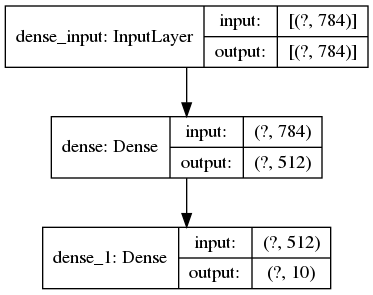

In [18]:
display(plot)

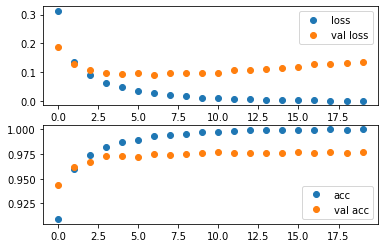

In [14]:
history = pd.DataFrame(training.history)

fig, ax = pyplot.subplots(2,1)
history['loss'].plot(ax=ax[0], style="o",label='loss')
history['val_loss'].plot(ax=ax[0], style="o",label='val loss')
ax[0].legend()
history['accuracy'].plot(ax=ax[1], style="o",label='acc')
history['val_accuracy'].plot(ax=ax[1], style="o",label='val acc')
ax[1].legend()

In [10]:
# Play Games with Reference NN Model
print("[+] Evaluate reference model \t>", end='', flush=True)
loss, accuracy  = evaluate_model(ml_model=ml_model, x = data['x_val'], y=data['y_val'])
print(f"\tAccuracy:{accuracy} | Loss:{loss} |")

625/625 [==============================] - 2s 2ms/step - loss: 0.1412 - accuracy: 0.9759
	Accuracy:0.9758999943733215 | Loss:0.14124155044555664 |


In [11]:
# >>>>>> Genetic Algorithm Section <<<<<<
print("\n********** Genetic Algorithm **********")
population = ga.generate_first_population_randomly()


********** Genetic Algorithm **********
[+] Creating Initial NN Model Population Randomly: Done > Takes 0.0002484321594238281 sec


In [12]:
len(population)

5

In [14]:
# Run Each Generation
generation_performance = {}
for current_generation in range(MAX_GENERATIONS):
    print(f"[+] Generation {current_generation+1} of {MAX_GENERATIONS}")

    # >>>>>> Training Phase <<<<<<
    print(f"\tTraining Models:", end='\n', flush=True)
    training_start = time.time()

    # Train all Models in Population
    for i,individual in enumerate(population):
        print(f"\t\tGenerating model for individual {i}", end='\n', flush=True)
        ga.generate_model_from_chromosome(data, individual)

    training_stop = time.time()
    print(f"Done > Takes {training_stop - training_start} sec", end='\n')

    # >>>>>> Evaluation Phase <<<<<<
    print(f"\tEvaluating Population: ", end='\n', flush=True)
    evaluation_start = time.time()

    for i,individual in enumerate(population):
        
        print(f"\t\tIndividual {i}", end='\n', flush=True)
        
        # Play the Games
        loss, accuracy =  individual.ml_model.evaluate(x=data['x_val'], y=data['y_val']) 
        
        # Update Chromosome Results
        individual.loss = loss
        individual.accuracy = accuracy
        

    evaluation_stop = time.time()
    print(f"Done > Takes {evaluation_stop - evaluation_start} sec", end='\n')

    # Sort Candidates by Sum of Results
    population.sort(key=lambda x: x.accuracy, reverse=True)

    # Compute Generation Metrics
    generation_performance[current_generation] = pd.DataFrame([{'loss':x.loss, 'accuracy': x.accuracy} for x in population ])
    
    generation_performance[current_generation].describe()

    # >>>>>> Genetic Selection, Children Creation and Mutation <<<<<<
    if current_generation < MAX_GENERATIONS-1:
        population = ga.evolve_population(population)

[+] Generation 1 of 100
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating model for individual 3
		Generating model for individual 4
Done > Takes 68.8868579864502 sec
	Evaluating Population: 
		Individual 0
625/625 [==============================] - 1s 2ms/step - loss: 0.2013 - accuracy: 0.9431
		Individual 1
625/625 [==============================] - 2s 3ms/step - loss: 1.0833 - accuracy: 0.6234
		Individual 2
625/625 [==============================] - 2s 3ms/step - loss: 1.7675 - accuracy: 0.5201
		Individual 3
625/625 [==============================] - 1s 2ms/step - loss: 2.3024 - accuracy: 0.1000
		Individual 4
625/625 [==============================] - 1s 2ms/step - loss: 2.3016 - accuracy: 0.1089
Done > Takes 7.984793424606323 sec
[+] Generation 2 of 100
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating m

KeyboardInterrupt: 